# Hit Left-right ambiguity classification

In this notebook we will try to use Keras and XGBoost to define a classifier to distinguish hits according to the correctness of their left-right ambiguity assignment

In [1]:
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, ReLU
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

2023-01-24 12:34:35.213421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Process the variables and select them as signal vs background.  We define 'signal' as when the measured DOCA sign (left-right ambiguity) is the same as the true sign, and background as the opposite.  We select active hits that were generated by the true particle.  We also bias the sample towards large drift distance, as wrong sign at large drift distance has a larger (negative) impact on the fit than wrong sign at smaller drift distance.

In [2]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
filelist = os.environ['KKTrainDriftFiles']
print("Using files in " + filelist)
files = open(filelist, 'r')
for filename in files:
    print("Processing: " + filename)    
    with uproot.open(filename) as file:
        trkana = file["TAKK"]["trkana"].arrays(filter_name="/de|detsh|detshmc|demc/i")
        trkana = trkana[(trkana['de.goodfit']==1)&(trkana['de.status']>0)&(trkana['demc.proc']==167)]
    udoca = ak.concatenate(trkana['detsh.udoca']).to_numpy()
    absudoca = np.absolute(udoca)
    cdrift = ak.concatenate(trkana['detsh.cdrift']).to_numpy()
    tottdrift = ak.concatenate(trkana['detsh.tottdrift']).to_numpy()
    edep = ak.concatenate(trkana['detsh.edep']).to_numpy()
    sint = ak.concatenate(trkana['detsh.wdot']).to_numpy()
    sint = np.sqrt(1.0-sint*sint)
    edep = edep*sint
    udocaerr = ak.concatenate(trkana['detsh.udocavar']).to_numpy()
    udocaerr = np.sqrt(udocaerr)
#    rderr = ak.concatenate(trkana['detsh.rtocavar']).to_numpy()
#    rderr = np.sqrt(rderr)
    hstate = ak.concatenate(trkana['detsh.state']).to_numpy()
    print("Processed file " + filename + " with %s hits"%udoca.shape[0])
#    temp = np.vstack((absudoca,cdrift,udocaerr,rderr,tottdrift, edep)).T
    temp = np.vstack((absudoca,cdrift,udocaerr,tottdrift, edep)).T
    
    if input_dataset is np.empty:
        input_dataset = temp
    else:
        input_dataset = np.concatenate((input_dataset, temp))
    mcrel = []
    mcambig = []
    mcdist = []
    for i, this_dt in enumerate(trkana['detsh.udoca']):
        mcrel.extend(trkana['detshmc.rel._rel'][i][:len(this_dt)])
        mcambig.extend(trkana['detshmc.ambig'][i][:len(this_dt)])
        mcdist.extend(trkana['detshmc.dist'][i][:len(this_dt)])
    mcrel = np.array(mcrel)
    mcambig = np.array(mcambig)
    mcdist = np.array(mcdist)
    mcdist = mcdist/2.5
    rand = np.random.random_sample([mcdist.shape[0]])

    sig = (hstate>-2) & (mcrel==0) & (rand<mcdist) & (mcambig*udoca>0) & (absudoca < 10.0)
    bkg = (hstate>-2) & (mcrel==0) & (rand<mcdist) & (mcambig*udoca<0) & (absudoca < 10.0)
    if signal is np.empty:
        signal = sig
        backgnd = bkg
    else:
        signal = np.concatenate((signal,sig))
        backgnd = np.concatenate((backgnd,bkg))    
nhits=len(input_dataset)
nsignal=signal.sum()
nbackgnd=backgnd.sum()
print("Total dataset %s hits, %s signal and %s background"%(nhits,nsignal,nbackgnd))

Using files in /Users/brownd/data/65661719/files.txt
Processing: /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000000.root

Processed file /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000000.root
 with 578423 hits
Processing: /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000010.root

Processed file /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000010.root
 with 581735 hits
Processing: /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000020.root

Processed file /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000020.root
 with 581740 hits
Processing: /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000030.root

Processed file /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000030.root
 with 577941 hits
Processing: /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000040.root

Processed file /Users/brownd/data/65661719/nts.brownd.KKDrift.KKDP.001210_00000040.root
 with

In our problem we have a different number of signal and background entries in our input dataset. There are several techniques avaialable for unbalanced datasets. Here we are using the most naive one, which is just using $\min(N_{sig}, N_{bkg})$ events. Then, we divide our input into the _training_, _validation_, and _test_ datasets.  Note that the training samples need to be a whole increment of the batch size.  We should be able to do better on the initialization, which is currently 100% signal, 0% background. TODO  

In [3]:
min_len = min(len(input_dataset[signal]), len(input_dataset[backgnd]))
bsize=32
tsize=2*bsize
min_len = min_len - min_len%tsize
print("Training on %s matched hits"%min_len)
signal_dataset = input_dataset[signal][:min_len]
bkg_dataset = input_dataset[backgnd][:min_len]

x_input = np.concatenate((signal_dataset, bkg_dataset))
y_input = np.concatenate((np.ones(signal_dataset.shape[0]), np.zeros(bkg_dataset.shape[0])))

n_variables = x_input.shape[1]

x_train, x_test, y_train, y_test = train_test_split(x_input, y_input, test_size=0.5, random_state=42)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

Training on 110784 matched hits


In [4]:
udoca_sig = []
tottdrift_sig = []
cdrift_sig = []
udocaerr_sig = []
rderr_sig = []
edep_sig = []
    
for i in range(signal_dataset.shape[0]):
    udoca_sig.append(signal_dataset[i][0])
    
for i in range(signal_dataset.shape[0]):
    cdrift_sig.append(signal_dataset[i][1])
    
for i in range(signal_dataset.shape[0]):
    udocaerr_sig.append(signal_dataset[i][2])

#for i in range(signal_dataset.shape[0]):
#    rderr_sig.append(signal_dataset[i][3])

for i in range(signal_dataset.shape[0]):
    tottdrift_sig.append(signal_dataset[i][3])
    
for i in range(signal_dataset.shape[0]):
    edep_sig.append(signal_dataset[i][4])

In [5]:
udoca_back = []
tottdrift_back = []
cdrift_back = []
udocaerr_back = []
#rderr_back = []
edep_back = []
    
for i in range(bkg_dataset.shape[0]):
    udoca_back.append(bkg_dataset[i][0])
    
for i in range(bkg_dataset.shape[0]):
    cdrift_back.append(bkg_dataset[i][1])
    
for i in range(bkg_dataset.shape[0]):
    udocaerr_back.append(bkg_dataset[i][2])

#for i in range(bkg_dataset.shape[0]):
#    rderr_back.append(bkg_dataset[i][3])

for i in range(bkg_dataset.shape[0]):
    tottdrift_back.append(bkg_dataset[i][3])

for i in range(bkg_dataset.shape[0]):
    edep_back.append(bkg_dataset[i][4])

<function matplotlib.pyplot.show(close=None, block=None)>

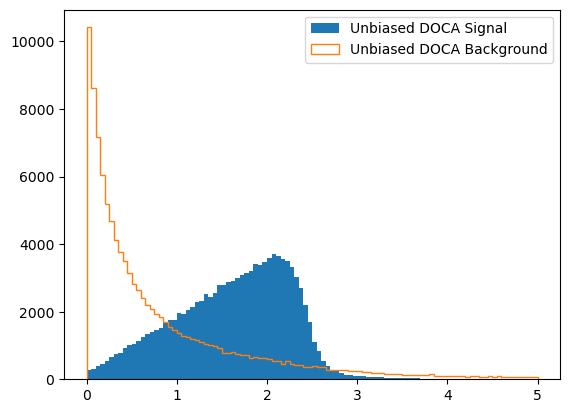

In [6]:
plt.hist(udoca_sig,label="Unbiased DOCA Signal", bins=100,range=(0,5))
plt.hist(udoca_back,label="Unbiased DOCA Background", histtype='step', bins=100,range=(0,5))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

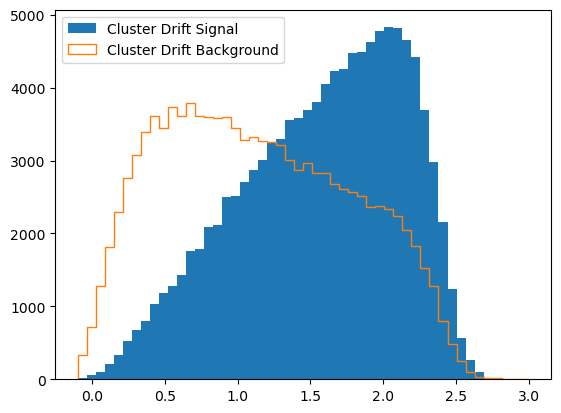

In [7]:
plt.hist(cdrift_sig,label="Cluster Drift Signal", bins=50,range=(-0.1,3.0))
plt.hist(cdrift_back,label="Cluster Drift Background", histtype='step', bins=50, range=(-0.1,3.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

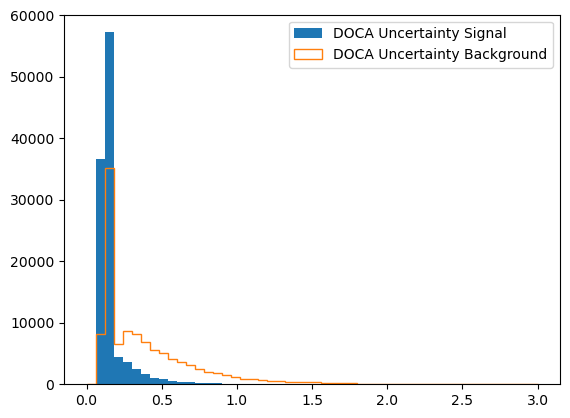

In [8]:
plt.hist(udocaerr_sig,label="DOCA Uncertainty Signal", bins=50,range=(0,3))
plt.hist(udocaerr_back,label="DOCA Uncertainty Background", histtype='step', bins=50,range=(0,3))
plt.legend()
plt.show

In [9]:
#plt.hist(rderr_sig,label="cdrift Uncertainty Signal", bins=50,range=(0,3))
#plt.hist(rderr_back,label="cdrift Uncertainty Background", histtype='step', bins=50,range=(0,3))
#plt.legend()
#plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

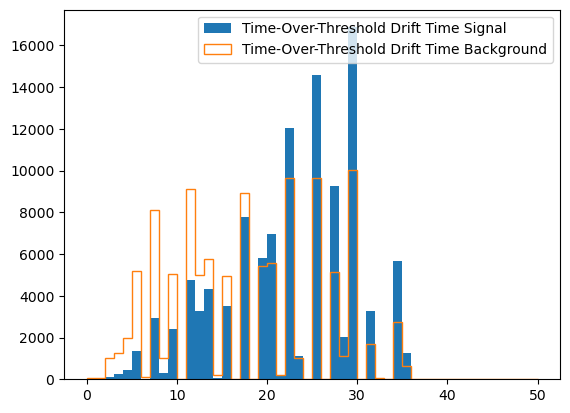

In [10]:
plt.hist(tottdrift_sig,label="Time-Over-Threshold Drift Time Signal", bins=50, range=(0,50))
plt.hist(tottdrift_back,label="Time-Over-Threshold Drift Time Background", histtype='step', bins=50,range=(0,50))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

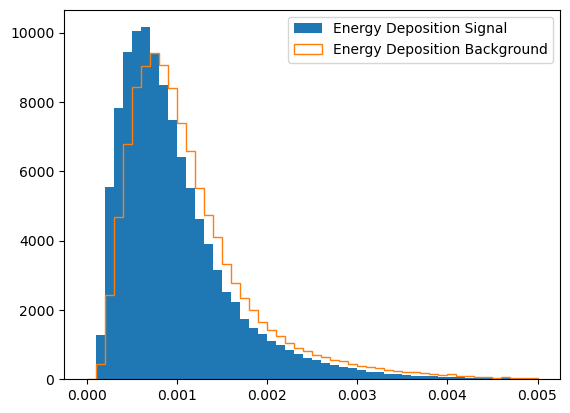

In [11]:
plt.hist(edep_sig,label="Energy Deposition Signal",bins=50,range=(0,0.005))
plt.hist(edep_back,label="Energy Deposition Background", histtype='step', bins=50, range=(0,0.005))
plt.legend()
plt.show

## Create and train a multi-layer perceptron

Here we create a _multi-layer perceptron_ (MLP) model which consists of 3 fully-connected (or _dense_) layers, each one followed by a _dropout_ layer, which helps to avoid overfitting. The model is trained using the [Adam](https://arxiv.org/abs/1412.6980) optimizer and trained until the validation loss doesn't improve for 10 epochs (`early_stop`). Instead of starting from scratch we should reload the previous model, that will greatly speed convergence.  TODO

In [12]:
lay0=Input(shape=(n_variables,),batch_size=1)
lay1=Dense(2*n_variables, activation='relu')(lay0)
lay2=Dense(2*n_variables, activation='relu')(lay1)
lay3=Dense(2*n_variables, activation='relu')(lay2)
lay4=Dense(1,activation='sigmoid')(lay3)
output_model=Model(inputs=lay0,outputs=lay4)

opt = Adam(learning_rate=1e-3)
input=Input(shape=(n_variables,),batch_size=bsize)
x=Dense(2*n_variables, activation='relu')(input)
x=Dense(2*n_variables, activation='relu')(x)
x=Dense(2*n_variables, activation='relu')(x)
output=Dense(1,activation='sigmoid')(x)
model=Model(inputs=input,outputs=output)
model.compile(loss='binary_crossentropy',metrics='accuracy',optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5, restore_best_weights=True)
history = model.fit(x_train, y_train,
                          batch_size=bsize,
                          epochs=200,
                          verbose=1,
                          validation_data=(x_valid, y_valid),
                          callbacks=[early_stop]
                         )

2023-01-24 12:45:26.486969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
3462/3462 [==============================] - 5s 1ms/step - loss: 0.4406 - accuracy: 0.8036 - val_loss: 0.3633 - val_accuracy: 0.8583
Epoch 2/200
3462/3462 [==============================] - 4s 1ms/step - loss: 0.3615 - accuracy: 0.8569 - val_loss: 0.3485 - val_accuracy: 0.8618
Epoch 3/200
3462/3462 [==============================] - 5s 1ms/step - loss: 0.3479 - accuracy: 0.8635 - val_loss: 0.3445 - val_accuracy: 0.8674
Epoch 4/200
3462/3462 [==============================] - 4s 1ms/step - loss: 0.3395 - accuracy: 0.8656 - val_loss: 0.3438 - val_accuracy: 0.8665
Epoch 5/200
3462/3462 [==============================] - 5s 1ms/step - loss: 0.3337 - accuracy: 0.8679 - val_loss: 0.3384 - val_accuracy: 0.8649
Epoch 6/200
3462/3462 [==============================] - 5s 1ms/step - loss: 0.3313 - accuracy: 0.8690 - val_loss: 0.3245 - val_accuracy: 0.8710
Epoch 7/200
3462/3462 [==============================] - 5s 1ms/step - loss: 0.3290 - accuracy: 0.8694 - val_loss: 0.3224 - val_ac

## Create and train a Boosted Decision Tree
Here, instead of using a MLP, we use a [_Gradient Boosted Decision Tree_](https://xgboost.readthedocs.io/en/stable/) (BDT) to distinguish the left-right ambiguity sign

In [13]:
model_xgboost = XGBClassifier()
model_xgboost.fit(x_train, y_train)

[12:49:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/brownd/mambaforge/envs/KKTrain/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Here we can finally apply our two models (the MLP and the BDT) to our test datasets and create the corresponding ROC curves.

In [14]:
prediction = model.predict(x_test).ravel()
fpr, tpr, th = roc_curve(y_test,  prediction)
auc = roc_auc_score(y_test, prediction)

1731/1731 [==============================] - 1s 633us/step


In [15]:
prediction_xgboost = model_xgboost.predict_proba(x_test)[:,1]
fpr_xgboost, tpr_xgboost, th_xgboost = roc_curve(y_test,  prediction_xgboost)
auc_xgboost = roc_auc_score(y_test, prediction_xgboost)

When the ANN training is optimized, it should be nearly as good as the BDT.  We use the ANN inference function, as that is faster to compute and is supported by the SOFIE tool applied downstream

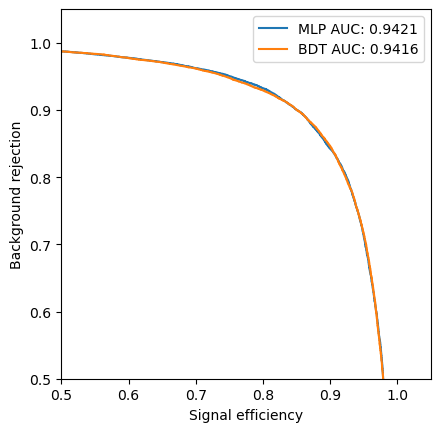

In [19]:
fig, ax = plt.subplots(1,1)
ax.plot(tpr,1-fpr,label=f'MLP AUC: {auc:.4f}')
ax.plot(tpr_xgboost,1-fpr_xgboost,label=f'BDT AUC: {auc_xgboost:.4f}')

ax.legend()
ax.set_aspect("equal")
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background rejection")
ax.set_xlim(0.5,1.05)
ax.set_ylim(0.5,1.05)
fig.savefig("TrainSignROC.pdf")

In [17]:
output_model.set_weights(model.get_weights())
output_model.summary()
output_model.save("TrainSign.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 5)]                  0         
                                                                 
 dense (Dense)               (1, 10)                   60        
                                                                 
 dense_1 (Dense)             (1, 10)                   110       
                                                                 
 dense_2 (Dense)             (1, 10)                   110       
                                                                 
 dense_3 (Dense)             (1, 1)                    11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________
